## Installing Libraries
numpy is a module for a variety of numeric operations and helper functions, but also linear algebra

In [1]:
import numpy as np

sklearn is a general machine learning and statistics module, for our purposes we grab the linear regression module

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNetCV, \
                                 Ridge, Lasso, LassoCV, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Get Performance metrics

In [3]:
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, confusion_matrix, roc_curve

pandas has some similar functionality to numpy but provides some improved
data processing steps functionality.

In [4]:
import pandas as pd

scipy is a general purpose scientific computing module

In [5]:
from scipy.linalg import svd
from scipy.stats import f

matplotlib is the primary plotting library for Python

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

Set plot style

In [7]:
plt.style.use('ggplot')

Function for loading MATLAB files

In [8]:
from scipy.io import loadmat

Additional library for plotting and visualization

In [9]:
import seaborn as sns

# Load data that we'll be using throughout today sessions

In [10]:
hsi = loadmat('HSIData.mat')

Let's take a look at what's in this `hsi` object

In [11]:
keys = hsi.keys()
print(keys)

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'Yarr', 'B', 'X', 'Xnoise', 'labels', 'label2', 'Ys', 'Yl', 'indx'])


Grab objects that we'll be using

In [12]:
Y = hsi['Y']
Yarr = hsi['Yarr']
lab = hsi['labels']
lab2 = hsi['label2']
X = hsi['X']
all_indx = np.arange(len(lab2))
train_indx = hsi['indx']
test_indx = np.delete(all_indx, train_indx)

# Visualization
Let's take a look at some of these objects

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


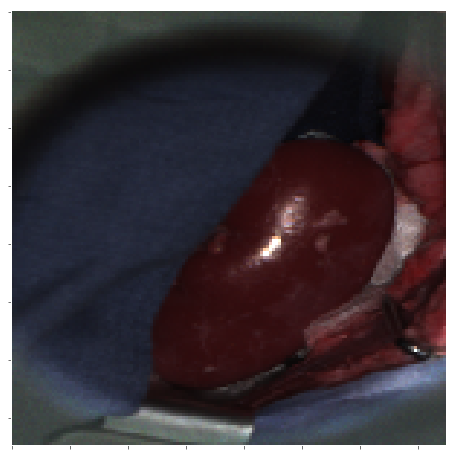

In [13]:
img_fig = plt.figure(figsize=(8, 8));
img_plot = img_fig.add_subplot(1,1,1);
img_plot.grid(False);
img_plot.imshow(Yarr[:,:,[100,50,10]]);
img_plot.set_xticklabels(['']*Yarr.shape[0]);
img_plot.set_yticklabels(['']*Yarr.shape[0]);

This is an image of a pig kidney, we've selected the channels most closely corresponding to the red, green and blue channels. Let's grab two wavelengths and visualize the distribution of classes, kidney vs. other. Let's visualize a sample from this image:

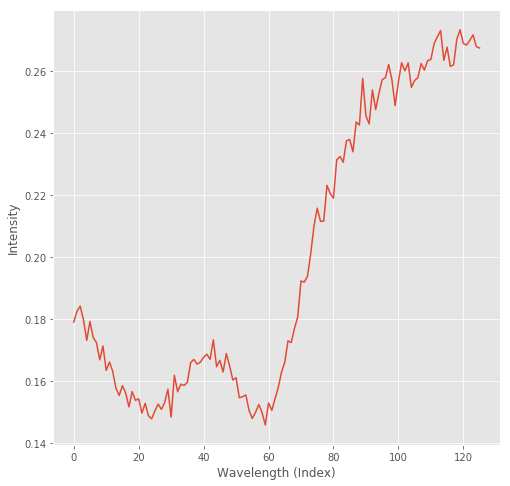

In [14]:
sample_fig = plt.figure(figsize=(8, 8));
sample_plot = sample_fig.add_subplot(1, 1, 1);
sample_plot.plot(Y[19000, :]);
sample_plot.set_xlabel('Wavelength (Index)');
sample_plot.set_ylabel('Intensity');

Next let's take a look at what the average spectral signature by object. First, calculate the average spectra.

In [15]:
endmembers = list()
for i in np.unique(lab):
    endmembers.append(Y[lab == i, :].mean(0))
endmembers = np.array(endmembers)
print(endmembers.shape)


(5, 126)


Then generate the plot

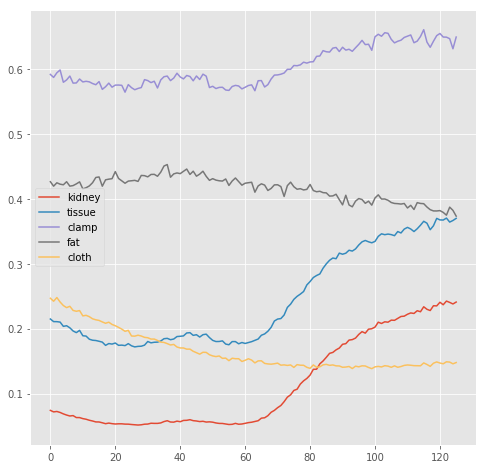

In [16]:
names = ['kidney', 'tissue', 'clamp', 'fat', 'cloth']
end_fig = plt.figure(figsize=(8, 8))
end_plot = end_fig.add_subplot(1, 1, 1)
for i in range(X.shape[1]):
    end_plot.plot(X[:, i], label=names[i])
end_plot.legend();

Next try plotting one of the endmembers in `X` against the spectra above

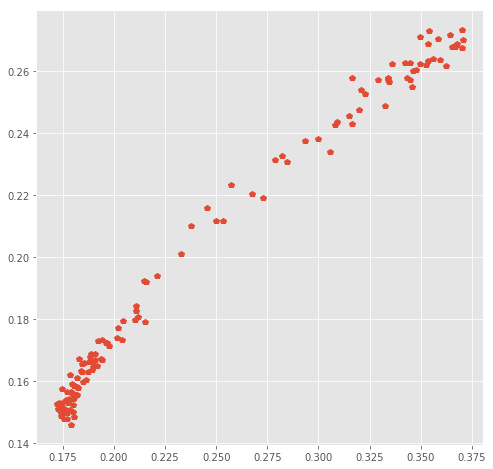

In [17]:
scat_fig = plt.figure(figsize=(8, 8))
scat_plot = scat_fig.add_subplot(1, 1, 1)
scat_plot.plot(X[:,1], Y[19000,:], 'p');

# Let's try fitting a regression model

In [18]:
LR = LinearRegression()
LR.fit(X[:,1].reshape(-1, 1), Y[19000,:])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's take a look at the predicted value vs. the observed data

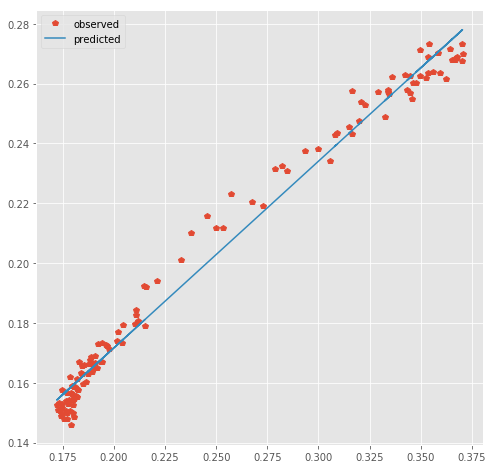

In [19]:
obsvsp, obsvsp_ax = plt.subplots(figsize=(8, 8))
obsvsp_ax.plot(X[:,1], Y[19000,:], 'p', label='observed');
obsvsp_ax.plot(X[:,1], LR.predict(X[:,1].reshape(-1, 1)), label='predicted');
obsvsp_ax.legend();

We can also look at this a slightly different way by considering the wavelength view

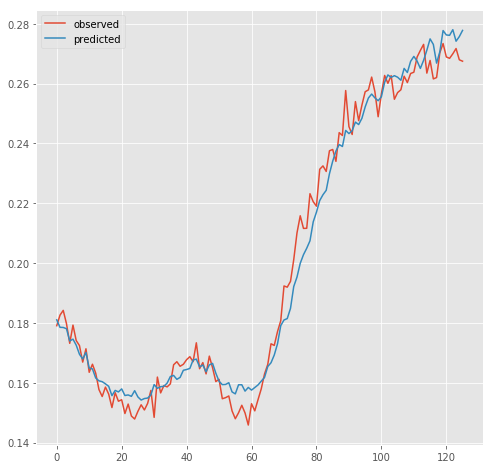

In [20]:
obsvsp2, obsvsp_ax2 = plt.subplots(figsize=(8, 8))
obsvsp_ax2.plot(Y[19000,:], label='observed');
obsvsp_ax2.plot(LR.predict(X[:,1].reshape(-1, 1)), label='predicted');
obsvsp_ax2.legend();

Now consider the multivariate case and visualize it

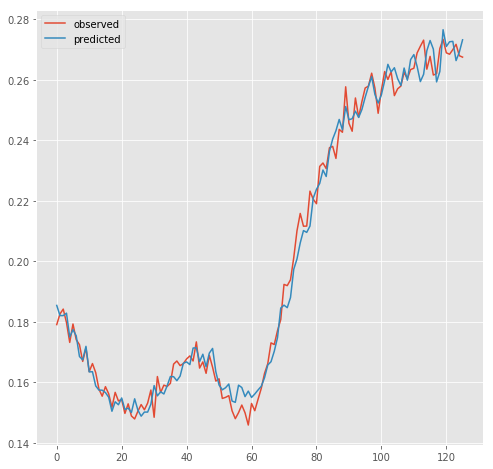

In [21]:
LR2 = LinearRegression()
LR2.fit(X, Y[19000,:])

obsvspm, obsvsp_axm = plt.subplots(figsize=(8, 8))
obsvsp_axm.plot(Y[19000,:], label='observed');
obsvsp_axm.plot(LR2.predict(X), label='predicted');
obsvsp_axm.legend();

A better fit, but when we were just looking at one endmember seemed to be just about as good. Let's look at the coefficient

In [22]:
LR2_df = pd.DataFrame([np.array(names), LR2.coef_]).T
LR2_df.columns = ['endmember', 'coefficient']
LR2_df

,endmember,coefficient
0,kidney,-0.582639
1,tissue,1.12875
2,clamp,0.102832
3,fat,-0.0272527
4,cloth,-0.0257501


These results look a bit odd... first, as mentioned in the lecture, we're not explicitly controlling for non-negativity. However, it's also important to note that _we are still including the intercept terms_. Let's try to refit without the intercept

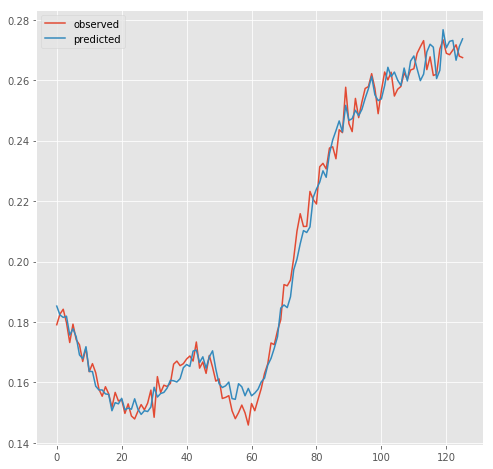

In [23]:
LR3 = LinearRegression(fit_intercept=False)
LR3.fit(X, Y[19000, :])

obsvspm2, obsvsp_axm2 = plt.subplots(figsize=(8, 8))
obsvsp_axm2.plot(Y[19000,:], label='observed');
obsvsp_axm2.plot(LR3.predict(X), label='predicted');
obsvsp_axm2.legend();

In [24]:
LR3_df = pd.DataFrame([np.array(names), LR3.coef_]).T
LR3_df.columns = ['endmember', 'coefficient']
LR3_df

,endmember,coefficient
0,kidney,-0.588631
1,tissue,1.16976
2,clamp,0.00401525
3,fat,-0.0426664
4,cloth,-0.0273542


So, somewhat similar. The `clamp` coefficient dropped down, but we still have kidney with a strong negative coefficient. This is likely (in part) due to the collinearity between `kidney` and `tissue`. Let's see if ridge regression can help here

In [25]:
RR = Ridge(alpha=0.005, fit_intercept=False)
RR.fit(X, Y[19000, :])

RR_df = pd.DataFrame([np.array(names), RR.coef_]).T
RR_df.columns = ['endmember', 'coefficient']
RR_df

,endmember,coefficient
0,kidney,0.00314239
1,tissue,0.525197
2,clamp,0.167815
3,fat,-0.0563852
4,cloth,-0.0422931


Try changing the value of `alpha` and see how that impacts the coefficient estimates. Note, overall the esimates seem a bit more intuitive, but having `clamp` in there seems a bit odd.

# Let's take a look at how each of these models performed

In [26]:
def adjr2_score(y_true, y_pred, p):
    r = r2_score(y_true, y_pred)
    return r - (1 - r) * (p - 1)/(len(y_true) - p)

def bic(y_true, y_pred, p):
    mse = mean_squared_error(y_true, y_pred)
    n = len(y_true)
    return n * np.log(mse) + p * np.log(n)

mse_res = [mean_squared_error(Y[19000, :], LR.predict(X[:, 1].reshape(-1, 1))),
           mean_squared_error(Y[19000, :], LR2.predict(X)),
           mean_squared_error(Y[19000, :], LR3.predict(X)),
           mean_squared_error(Y[19000, :], RR.predict(X))]
r2 = [r2_score(Y[19000, :], LR.predict(X[:, 1].reshape(-1, 1))),
      r2_score(Y[19000, :], LR2.predict(X)),
      r2_score(Y[19000, :], LR3.predict(X)),
      r2_score(Y[19000, :], RR.predict(X))]
adjr2 = [adjr2_score(Y[19000, :], LR.predict(X[:, 1].reshape(-1, 1)), 1),
      adjr2_score(Y[19000, :], LR2.predict(X), 6),
      adjr2_score(Y[19000, :], LR3.predict(X), 5),
      adjr2_score(Y[19000, :], RR.predict(X), 5)]
bic_res = [bic(Y[19000, :], LR.predict(X[:, 1].reshape(-1, 1)), 1),
      bic(Y[19000, :], LR2.predict(X), 6),
      bic(Y[19000, :], LR3.predict(X), 5),
      bic(Y[19000, :], RR.predict(X), 5)]

perf_df = pd.DataFrame([['Univariate Regression', 'Multivariate Regressions (w/ Intercept)',
                       'Multivariate Regression (w/o Intercept)', 'Ridge Regression'], mse_res, r2, adjr2, bic_res]).T
perf_df.columns = ['Model', 'MSE', 'R2', 'Adj R2', 'BIC']
perf_df

,Model,MSE,R2,Adj R2,BIC
0,Univariate Regression,3.38685e-05,0.983855,0.983855,-1292.08
1,Multivariate Regressions (w/ Intercept),1.99995e-05,0.990466,0.990069,-1334.28
2,Multivariate Regression (w/o Intercept),2.04095e-05,0.990271,0.989949,-1336.56
3,Ridge Regression,3.26226e-05,0.984449,0.983934,-1277.46


In all instances the results seem to point to `Multivariate Regressions (w/ Intercept)`. That said, in application we have to balance interpretability and performance. 

Next let's try out the LASSO. 

In [27]:
L1 = Lasso(alpha=0.0001, fit_intercept=False)
L1.fit(X, Y[19000,:])

print(L1.coef_)

[ 0.          0.5687323   0.10000107  0.         -0.        ]


An interesting result! Let's take a look at how it performs relative to the other models we've already looked at

In [28]:
L1_res = pd.DataFrame(['Lasso (alpha=0.0001)', 
          mean_squared_error(Y[19000, :], L1.predict(X)),
          r2_score(Y[19000, :], L1.predict(X)),
          adjr2_score(Y[19000, :], L1.predict(X), sum(L1.coef_ != 0)),
          bic(Y[19000, :], L1.predict(X), sum(L1.coef_ != 0))]).T
L1_res.columns = perf_df.columns
perf2_df = perf_df.append(L1_res)
perf2_df

,Model,MSE,R2,Adj R2,BIC
0,Univariate Regression,3.38685e-05,0.983855,0.983855,-1292.08
1,Multivariate Regressions (w/ Intercept),1.99995e-05,0.990466,0.990069,-1334.28
2,Multivariate Regression (w/o Intercept),2.04095e-05,0.990271,0.989949,-1336.56
3,Ridge Regression,3.26226e-05,0.984449,0.983934,-1277.46
0,Lasso (alpha=0.0001),3.37899e-05,0.983892,0.983762,-1287.54


As it turns out `Lasso` allows us to include a positivity constraint, as follows

In [29]:
L2 = Lasso(alpha=0.0001, fit_intercept=False, positive=True)
L2.fit(X, Y[19000,:])

print(L2.coef_)

[0.         0.5687323  0.10000107 0.         0.        ]


So, basically the same as what we'd found above, but still useful to have in mind. The next useful step (in the context of abundance estimation type problems) would be to include a sum-to-one constraint. If enough people are interested we can come back to how to implement this.

As a follow up exercise, try to implement the Elastic Net. Once you've had a chance to do this let's go ahead an generate the "solution path" for the Lasso.

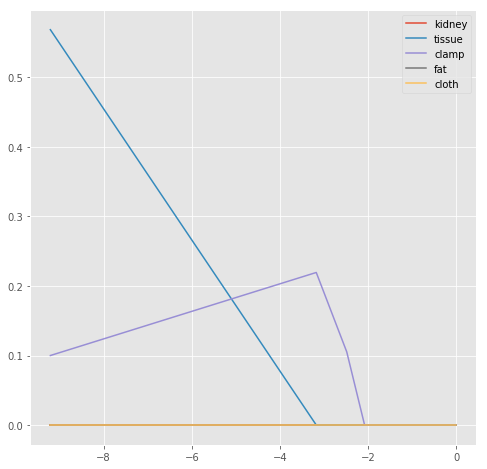

In [30]:
alpha_seq = np.linspace(1e-4, 1.0, 25)
lasso_coef = list()
for a in alpha_seq:
    L1_tmp = Lasso(alpha=a, fit_intercept=False)
    L1_tmp.fit(X, Y[19000, :])
    lasso_coef.append(L1_tmp.coef_)

lasso_coef = np.array(lasso_coef)

l1_fig, l1_ax = plt.subplots(figsize=(8, 8))
for i in range(lasso_coef.shape[1]):
    l1_ax.plot(np.log(alpha_seq), lasso_coef[:, i], label=names[i]);
    l1_ax.legend();

# Visualizing the results from the regression
From our preliminary analysis we saw that regular regression without an intercept was the best fit. We'll walk through how to generate a heatmap with abunces. As an additional exercise try to implement this using some of the other models.

We'll need to analyze each pixel in our matrix `Y`

In [31]:
abund_L1 = list()

for i in range(Y.shape[0]):
    L1_tmp = Lasso(alpha=0.00001)
    L1_tmp.fit(X, Y[i, :])
    abund_L1.append(L1_tmp.coef_)
    
abund_L1 = np.array(abund_L1)

/opt/conda/envs/lab/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [32]:
print(abund_L1.shape)

(22500, 5)


Note, in general we'd want to do something a bit more robust than pick a fixed value of `alpha`. As an exercise take a look at `LassoCV`. Recall that CV (cross-validation) allows us to more objectively select an appropriate alpha at a given pixel. Next we'll plo these results

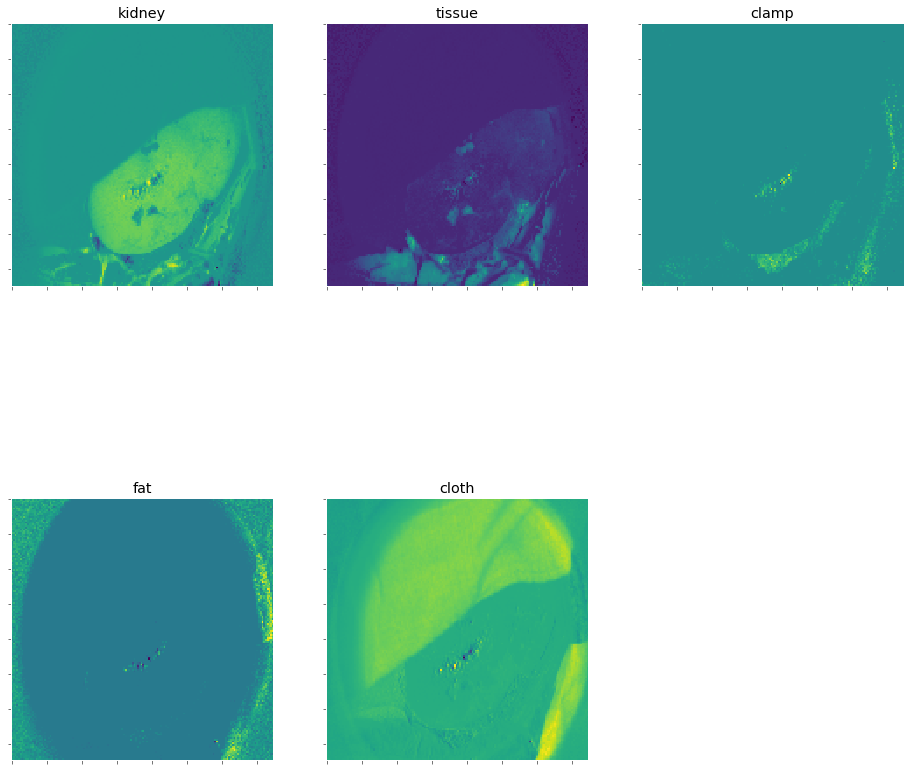

In [33]:
l1_heatmap, l1_map = plt.subplots(2, 3, figsize=(16, 16))
k = 0
for i in range(2):
    for j in range(3):
        l1_map[i, j].imshow(abund_L1[:,k].reshape(150, 150))
        l1_map[i, j].grid(False);
        l1_map[i, j].set_xticklabels(['']*150);
        l1_map[i, j].set_yticklabels(['']*150);
        l1_map[i, j].set_title(names[k])
        k += 1
        if k >= abund_L1.shape[1]:
            break
l1_heatmap.delaxes(l1_map[1, 2])

# Next we'll look at the classification problem
We begin by looking at a couple of plots

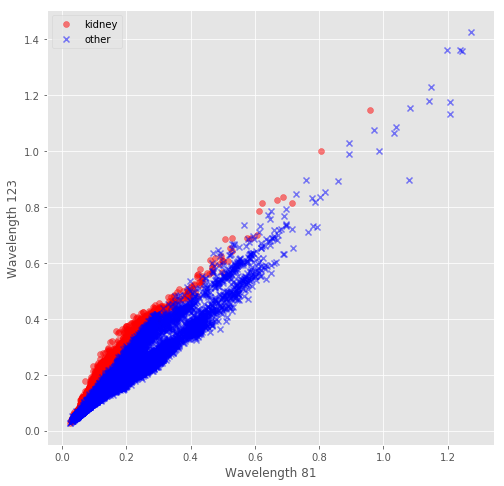

In [34]:
kid2_fig = plt.figure(figsize=(8,8));
kid2_class = kid2_fig.add_subplot(1, 1, 1);
kid2_mark = ['o', 'x'];
kid2_col = ['red', 'blue'];
kid2_leg = ['kidney', 'other'];
for i in range(2):
    ind = lab2 == i + 1
    kid2_class.scatter(Y[ind,80], Y[ind,122], color=kid2_col[i], 
                       marker=kid2_mark[i], label = kid2_leg[i], alpha=0.5);
kid2_class.set_xlabel('Wavelength 81');
kid2_class.set_ylabel('Wavelength 123');
kid2_class.legend();

Next lets plot the image with the 2 class labels. Since we're going to be reusing this set of plots let's write a simple function to simplify things

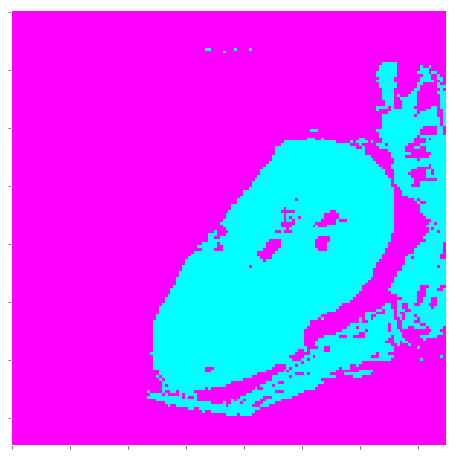

In [35]:
def plot_labels(l,s,cmap='cool'):
    fig = plt.figure(figsize=(8,8))
    plot = fig.add_subplot(1,1,1)
    plot.grid(False)
    plot.imshow(np.reshape(l, s).T, cmap=cmap)
    plot.set_xticklabels(['']*s[0])
    plot.set_yticklabels(['']*s[0])

plot_labels(lab2, (Yarr.shape[0],Yarr.shape[1]));

Check out https://matplotlib.org/examples/color/colormaps_reference.html for color options. 

Next, let's run LDA

In [36]:
lda = LinearDiscriminantAnalysis(solver='lsqr')
lda.fit(Y[train_indx,:], lab2[train_indx])
p_lda = lda.predict_proba(Y[test_indx,:])
l_lda = lda.predict(Y[test_indx,:])
confusion_matrix(lab2[test_indx], l_lda)

array([[ 5616,   625],
       [ 1304, 14705]])

Visualize results

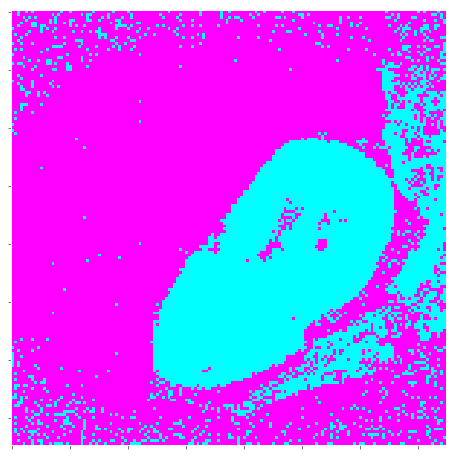

In [37]:
plot_labels(lda.predict(Y), (Yarr.shape[0], Yarr.shape[1]))

Try out sparse LDA

In [38]:
slda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=0.9)
slda.fit(Y[train_indx,:], lab2[train_indx])
p_slda = slda.predict_proba(Y[test_indx,:])
l_slda = slda.predict(Y[test_indx,:])
confusion_matrix(lab2[test_indx], l_slda)

array([[ 6036,   205],
       [  975, 15034]])

Look at the classification results

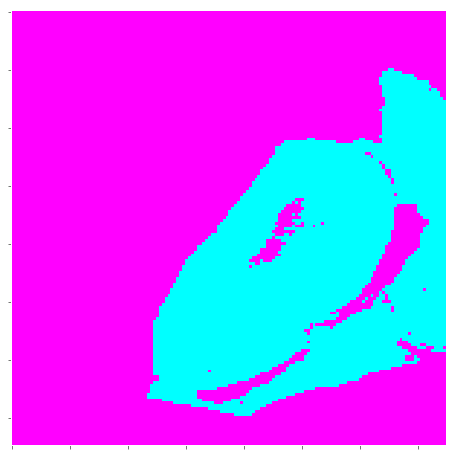

In [39]:
plot_labels(slda.predict(Y), (Yarr.shape[0],Yarr.shape[1]))

Let's take a look at some performance metrics

In [40]:
aroc_lda = roc_auc_score(lab2[test_indx]-1, p_lda[:,1])
aroc_slda = roc_auc_score(lab2[test_indx]-1, p_slda[:,1])

print(aroc_lda)
print(aroc_slda)

0.9640872374615348
0.9847002020344489


Next let's take a look at the AUC plot

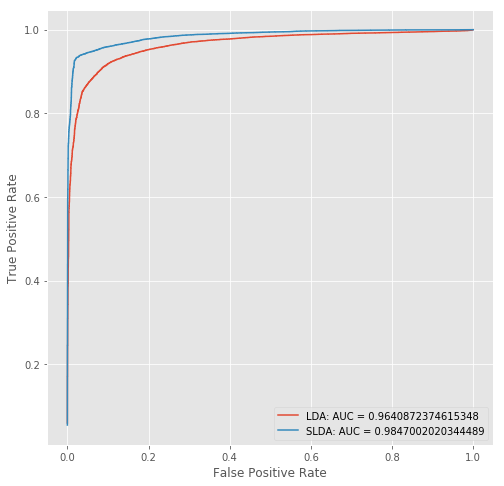

In [41]:
roc_lda = roc_curve(lab2[test_indx]-1, p_lda[:,1])
roc_slda = roc_curve(lab2[test_indx]-1, p_slda[:,1])

roc_fig = plt.figure(figsize=(8,8))
roc_plot = roc_fig.add_subplot(1,1,1)
roc_plot.plot(roc_lda[0], roc_lda[1], label = 'LDA: AUC = ' + str(aroc_lda))
roc_plot.plot(roc_slda[0], roc_slda[1], label = 'SLDA: AUC = ' + str(aroc_slda))
roc_plot.legend()
roc_plot.set_xlabel('False Positive Rate');
roc_plot.set_ylabel('True Positive Rate');

Try out logistic regression

In [42]:
lr = LogisticRegression(C=1e6, fit_intercept=False)
lr.fit(Y[train_indx,:], lab2[train_indx])
p_lr = lr.predict_proba(Y[test_indx,:])
l_lr = lr.predict(Y[test_indx,:])
aroc_lr = roc_auc_score(lab2[test_indx]-1, p_lr[:,1])

and sparse logistic regression

In [43]:
slr = LogisticRegression(C=1.0, fit_intercept=False, penalty='l1')
slr.fit(Y[train_indx,:], lab2[train_indx])
p_slr = slr.predict_proba(Y[test_indx,:])
l_slr = slr.predict(Y[test_indx,:])
aroc_slr = roc_auc_score(lab2[test_indx]-1, p_slr[:,1])

then visualize the results

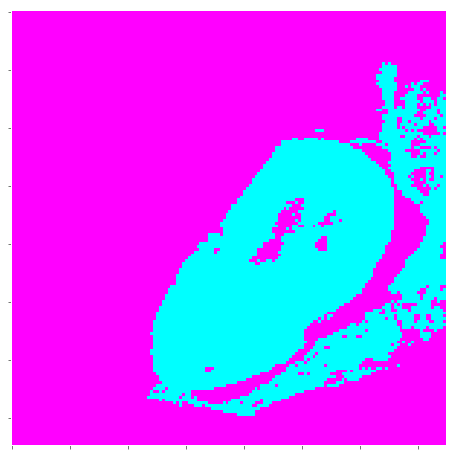

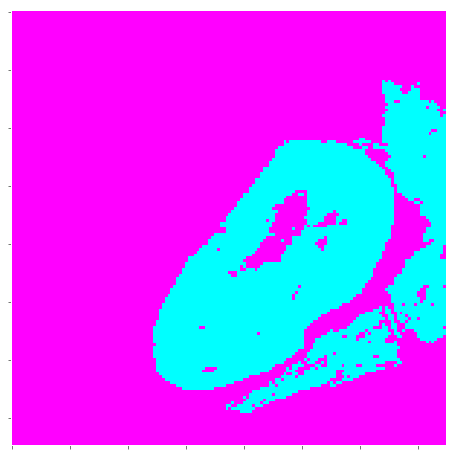

In [44]:
lr_fig = plot_labels(lr.predict(Y), (Yarr.shape[0],Yarr.shape[1]))
slr_fig = plot_labels(slr.predict(Y), (Yarr.shape[0],Yarr.shape[1]))

finally look at the AUC curves

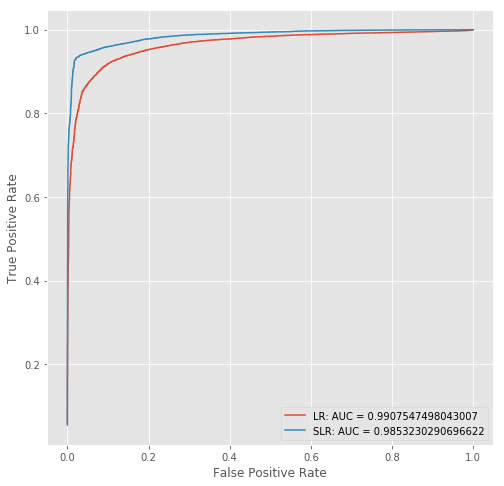

In [45]:
roc_lr = roc_curve(lab2[test_indx]-1, p_lr[:,1])
roc_slr = roc_curve(lab2[test_indx]-1, p_slr[:,1])

roc_lrfig = plt.figure(figsize=(8,8))
roc_lrplot = roc_lrfig.add_subplot(1,1,1)
roc_lrplot.plot(roc_lda[0], roc_lda[1], 
                label = 'LR: AUC = ' + str(aroc_lr))
roc_lrplot.plot(roc_slda[0], roc_slda[1], 
                label = 'SLR: AUC = ' + str(aroc_slr))
roc_lrplot.legend()
roc_lrplot.set_xlabel('False Positive Rate');
roc_lrplot.set_ylabel('True Positive Rate');

In most applications model interpretability is critical. A limitation of many "black box" methods such as random forest, neural nets, etc. is that actually understanding what is driving the model's decision isn't clear. For the purpose of scientific discovery this limitation is often an impediment to actually using these methods. The benefit of something like logistic regression is that it lends itself more readily to this type of transparency. Consider for example the plot below 

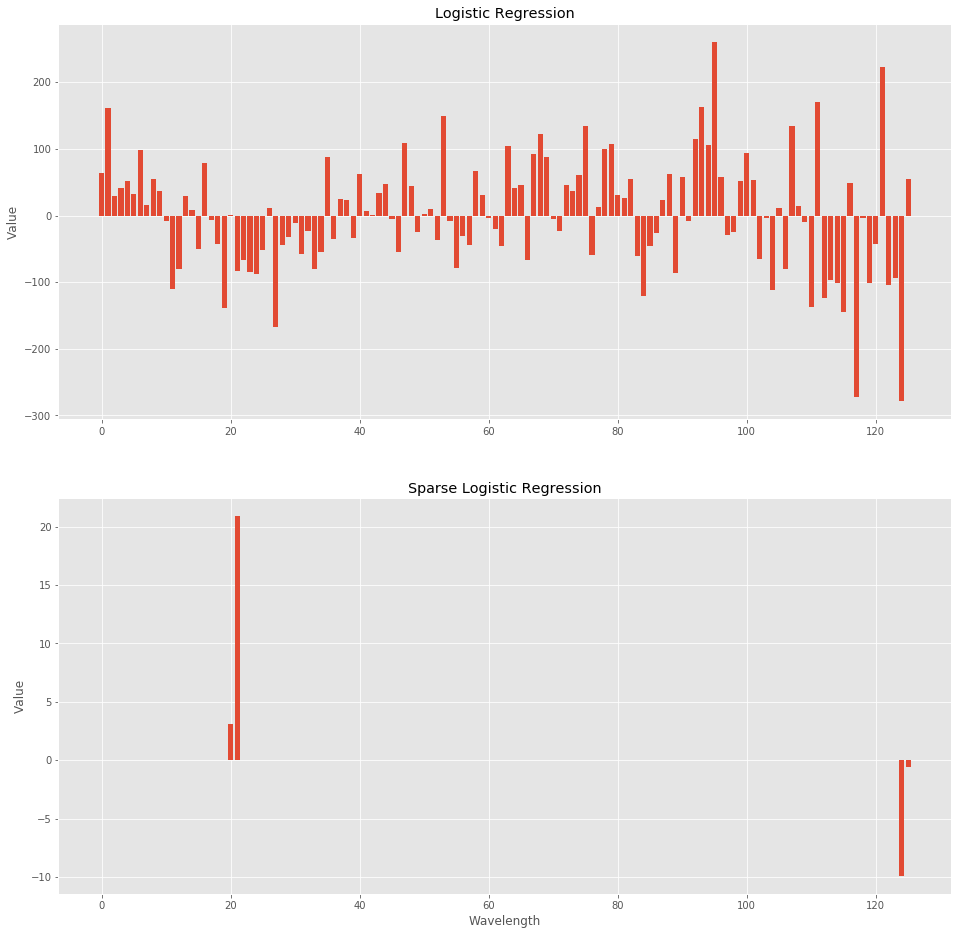

In [46]:
coefs_fig = plt.figure(figsize=(16, 16))
lr_coefs_plot = coefs_fig.add_subplot(2, 1, 1)
lr_coefs_plot.bar(np.arange(Y.shape[1]), lr.coef_[0])
lr_coefs_plot.set_title('Logistic Regression');
lr_coefs_plot.set_ylabel('Value');

slr_coefs_plot = coefs_fig.add_subplot(2, 1, 2)
slr_coefs_plot.bar(np.arange(Y.shape[1]), slr.coef_[0])
slr_coefs_plot.set_title('Sparse Logistic Regression');
slr_coefs_plot.set_ylabel('Value');
slr_coefs_plot.set_xlabel('Wavelength');

With all that being said more recent methods have tried to directly address this model interpretability issue. There are a variet of approaches but two in particular have really stood out (and I've used) are LIME and Shapley Values. If there is time/interest we'll take a closer look at these approaches.

# Multiclass classification
Next let's consider the multiclass problem. One of the beautiful things about the `sklearn` module is that the syntax is so consistent, making implementation straightforward. 

In [47]:
mlr = LogisticRegression(C=1e6, fit_intercept=False, multi_class='multinomial',
                         solver='lbfgs')
mlr.fit(Y[train_indx,:], lab[train_indx])
p_mlr = mlr.predict(Y[test_indx,:])
pd.DataFrame(confusion_matrix(lab[test_indx], p_mlr))

,0,1,2,3,4
0,5887,311,43,0,0
1,262,1073,35,0,0
2,0,43,651,131,0
3,0,14,137,3855,80
4,15,9,85,3,9616


And the sparse varient

In [48]:
smlr = LogisticRegression(C=1000, fit_intercept=False,
                          penalty='l1', solver='liblinear')
smlr.fit(Y[train_indx,:], lab[train_indx])
p_smlr = smlr.predict(Y[test_indx,:])
pd.DataFrame(confusion_matrix(lab[test_indx], p_smlr))

,0,1,2,3,4
0,5909,208,106,16,2
1,345,898,118,9,0
2,1,84,674,62,4
3,3,17,239,3765,62
4,23,3,100,0,9602


Visualize the results

Ground Truth
Multinomial Model
Sparse Multimnomial Model


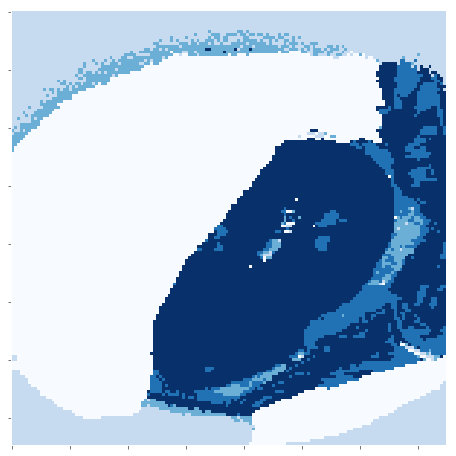

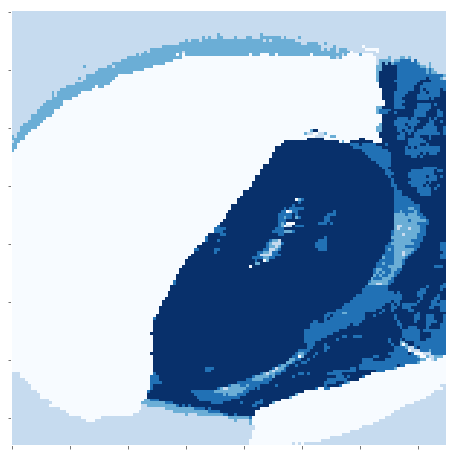

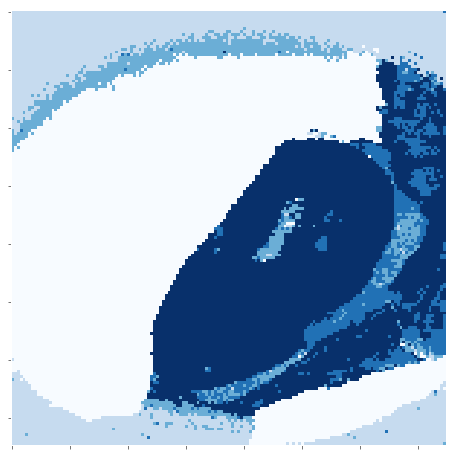

In [49]:
print('Ground Truth')
mclass_fig = plot_labels(lab, (Yarr.shape[0],Yarr.shape[1]), 
                         cmap = plt.cm.Blues_r)
print('Multinomial Model')
mclass_lr_fig = plot_labels(mlr.predict(Y), (Yarr.shape[0],Yarr.shape[1]), 
                            cmap = plt.cm.Blues_r)
print('Sparse Multimnomial Model')
mclass_slr_fig = plot_labels(smlr.predict(Y), (Yarr.shape[0],Yarr.shape[1]), 
                             cmap = plt.cm.Blues_r)

Next let's try fitting SVM

array([[ 5635,   606],
       [  449, 15560]])

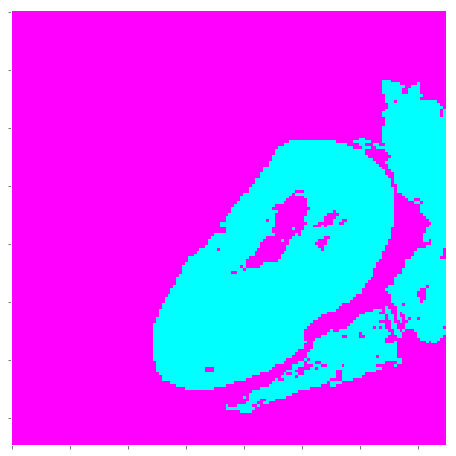

In [50]:
lsvc = svm.SVC(kernel='linear')
lsvc.fit(Y[train_indx,:], lab2[train_indx])
l_lsvc = lsvc.predict(Y[test_indx,:])
lsvc_fig = plot_labels(lsvc.predict(Y), (Yarr.shape[0],Yarr.shape[1]))
confusion_matrix(lab2[test_indx], l_lsvc)

And next kernel SVM

array([[ 5518,   723],
       [  406, 15603]])

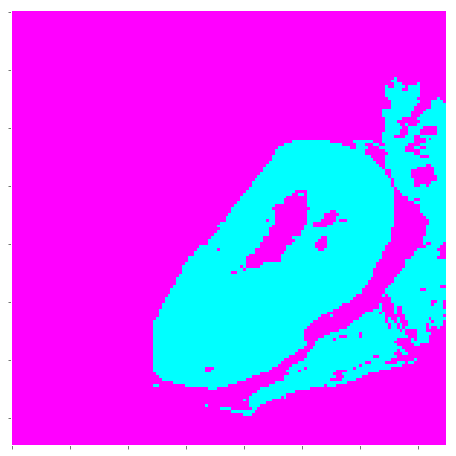

In [51]:
ksvc = svm.SVC(kernel='rbf', gamma = 0.5)
ksvc.fit(Y[train_indx,:], lab2[train_indx])
l_ksvc = ksvc.predict(Y[test_indx,:])
ksvc_fig = plot_labels(ksvc.predict(Y), (Yarr.shape[0],Yarr.shape[1]))
confusion_matrix(lab2[test_indx], l_ksvc)

Multiclass SVM

,0,1,2,3,4
0,5920,252,69,0,0
1,369,936,65,0,0
2,0,19,744,62,0
3,0,6,302,3763,15
4,23,0,142,26,9537


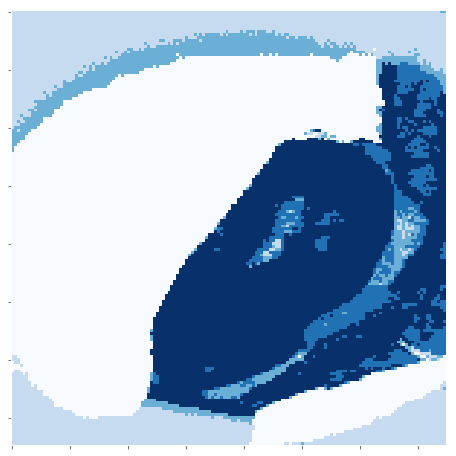

In [52]:
lmsvc = svm.SVC(kernel='linear', C=1000)
lmsvc.fit(Y[train_indx,:], lab[train_indx])
l_lmsvc = lmsvc.predict(Y[test_indx,:])
lmsvc_fig = plot_labels(lmsvc.predict(Y), (Yarr.shape[0],Yarr.shape[1]), 
                        plt.cm.Blues_r)
pd.DataFrame(confusion_matrix(lab[test_indx], l_lmsvc))

Multiclass kernel SVM

,0,1,2,3,4
0,5976,207,57,1,0
1,293,1020,56,1,0
2,9,40,658,117,1
3,0,37,299,3721,29
4,24,30,137,94,9443


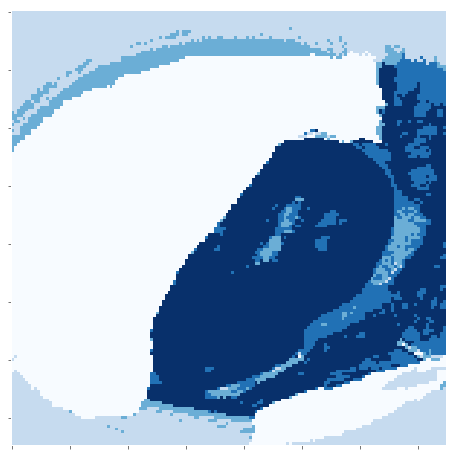

In [53]:
kmsvc = svm.SVC(kernel='rbf', gamma = 0.5, C=1000)
kmsvc.fit(Y[train_indx,:], lab[train_indx])
l_kmsvc = kmsvc.predict(Y[test_indx,:])
kmsvc_fig = plot_labels(kmsvc.predict(Y), (Yarr.shape[0],Yarr.shape[1]), 
                        plt.cm.Blues_r)
pd.DataFrame(confusion_matrix(lab[test_indx], l_kmsvc))

Next try a simple NN

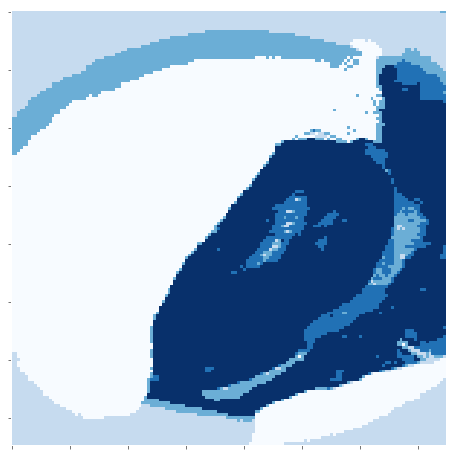

In [54]:
mlp = MLPClassifier(hidden_layer_sizes=(50,50,))
mlp.fit(Y[train_indx,:], lab[train_indx])
l_mlp = mlp.predict(Y[test_indx,:])
pd.DataFrame(confusion_matrix(lab[test_indx], l_mlp))

mlp_fig = plot_labels(mlp.predict(Y), (Yarr.shape[0],Yarr.shape[1]), 
                        plt.cm.Blues_r)

In [55]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
rfc = RandomForestClassifier(10)

[[5752  479   17    0   32]
 [ 329  773   69  161   46]
 [ 145  110  590  341  502]
 [  15    8  129 3185  143]
 [   0    0   20  399 9005]]


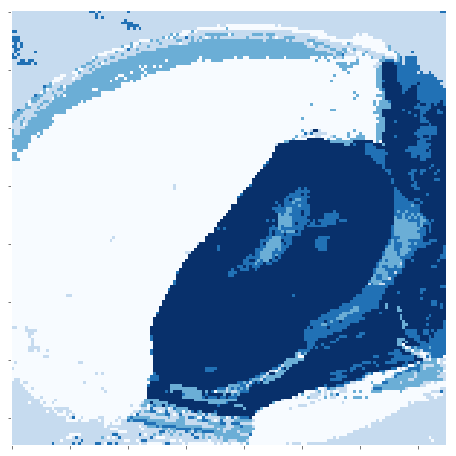

In [127]:
rfc.fit(Y[train_indx, :], lab[train_indx])
print(confusion_matrix(rfc.predict(Y[test_indx, :]), lab[test_indx]))
plot_labels(rfc.predict(Y), Yarr.shape[:2],
            plt.cm.Blues_r)

p = rfc.predict_proba(Y[test_indx, :])
# aroc = roc_auc_score(lab[test_indx]-1, p[:,0])
rf_roc = roc_curve(lab[test_indx]-1, p[:,0], pos_label=0)


[[5746  461   11    2    8]
 [ 320  770   53   52   17]
 [ 139  100  544  479  302]
 [  23   34  197 3326  193]
 [  13    5   20  227 9208]]


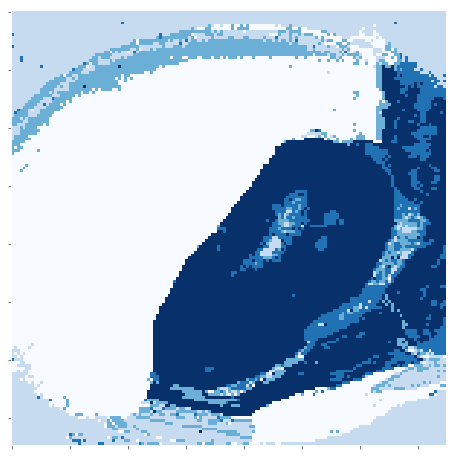

In [130]:
from sklearn.ensemble import GradientBoostingClassifier

xgb = GradientBoostingClassifier()
xgb.fit(Y[train_indx, :], lab[train_indx])
print(confusion_matrix(xgb.predict(Y[test_indx, :]), lab[test_indx]))
plot_labels(xgb.predict(Y), (Yarr.shape[0],Yarr.shape[1]), 
            plt.cm.Blues_r)
    
p = xgb.predict_proba(Y[test_indx, :])
xg_roc = roc_curve(lab[test_indx]-1, p[:,0], pos_label=0)

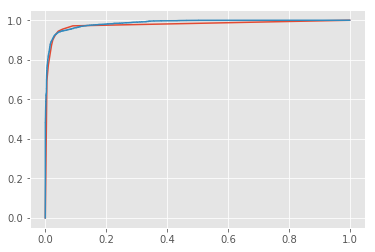

In [132]:
plt.figure()
plt.plot(rf_roc[0], rf_roc[1])
plt.plot(xg_roc[0], xg_roc[1])